# Tree Model Interpretation using SHAP

There are many techniques, each with advantages and disadvantages that can be suitable for different situations. [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, and is well-suited for exploring feature importances.

Pros:

- Mathematical theory behind explanation of the model.
- Very wide application and ease of use. Explanations on single sample and global level, and a number of graphs that can be very easily computed and understood.
- Feature interactions taken into account by the method.
- High computation speed, especially for the TreeExplainer

Cons:

- Documentation is often lacking.
- Different API when you use sklearn models e.g. RandomForestClassifier.
- Slow computation for some explainers e.g. KernelExplainer.

Let's assume we want to analyse the following model:

In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
 
feature_names = ['f1', 'f2', 'f3', 'f4']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, n_features=4, random_state=0)
X = pd.DataFrame(X, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Prepare and fit model. Remember about class_weight="balanced" or an equivalent.
clf = RandomForestClassifier(class_weight='balanced', n_estimators = 100, max_depth=2, random_state=0)
clf = clf.fit(X_train, y_train)

## ShapModelInterpreter

The `ShapModelInterpreter` class in Probatus, is a convenience wrapper class that allows to easily interpret the ML models. It implements multiple plotting methods, for **tree-based models**.

### Feature importance
Firstly, lets compute the feature importance. In SHAP, feature importance can be computed using mean absolute shap value per feature on the test set. It can be interpreted as strength of influence of a given feature on output probabilities.

In [2]:
from probatus.interpret import ShapModelInterpreter
 
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
feature_importance

,mean_abs_shap_value,mean_shap_value
f1,0.286270,0.018898
f4,0.120796,-0.007201
f3,0.050017,-0.005159
f2,0.006031,0.002337


The plot can be generated as follows:

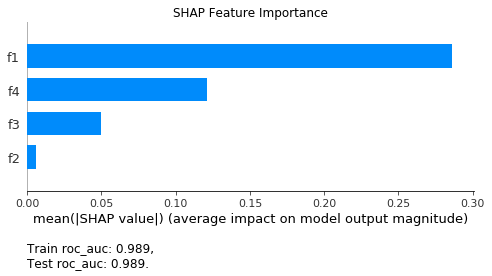

In [3]:
ax = shap_interpreter.plot('importance')

The AUC on train and test sets is illustrated in each plot, in order to illustrate if the model overfits. If you see that Test AUC is significantly lower than Train AUC, this is a sign that the model might be overfitting. In such case, the interpretation of the model might be misleading. In such situations we recommend retraining the model with more regularization.

### Summary plot

Summary plot gives you more insights into how different feature values affect predictions made. This is a very crucial plot to make for every model. Each dot on the X-axis represents a sample in the data, and strongly it affected the prediction (together with predictions direction). The colours of the dots, present the values of that feature. For each model try to analyse this plot with Subject Matter Expert, in order to make sure that the relations that the model has learned make sense.

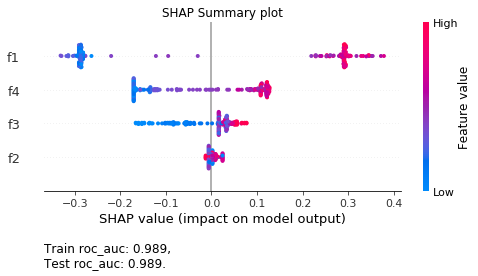

In [4]:
ax = shap_interpreter.plot('summary')


### Dependence Plot

This plot allows you to understand how the model reacts for different feature values. You can plot it for each feature in your model, or at least the top 10 features. This can provide you with further insights on how the model uses each of the features. Moreover, one can detect anomalies, as well as the effect of the outliers on the model. 

As an addition, the bottom plot, presents the feature distribution histogram, and the target rate for different buckets within that feature values. This allows to further analyse how the feature correlates with the target variable.

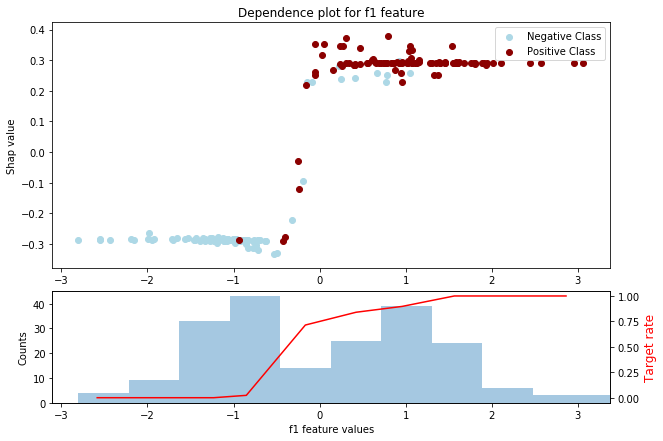

In [5]:
ax = shap_interpreter.plot('dependence', target_columns=['f1'])

### Sample explanation

In order to explain predictions for specific samples from your test set, you can use sample plot. For a given sample, the plot presents the force and direction of prediction shift that each feature value causes.

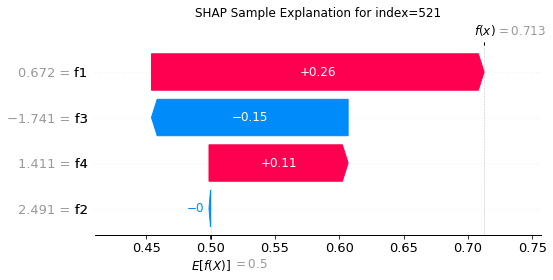

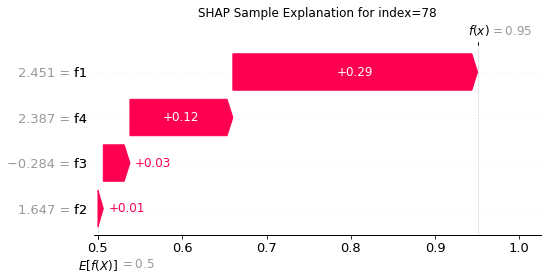

In [6]:
ax = shap_interpreter.plot('sample', samples_index=[521, 78])


### Tips for using the interpreter

Before using the ShapModelInterpreter consider the following tips:

- Fit your model using class weights set to 'balanced' setting, in order to make sure that Shap values are balanced between classes. If this setting is not available, try to balance the classes (under- or oversample before fitting the model).
- Make sure you do not underfit or overfit the model. Underfitting will cause only the most important relations in the data to be visible, while overfitting will present relationships that do not generalize.
- Perform feature selection process before fitting the final model. This way, many it will be easier to interpret the explanation. Moreover, highly-correlated features will affect the explanation less.
- Preferably use model that handles NaNs e.g. LightGBM or impute them before using SHAP. When imputing also extract a MissingIndicator to get insights into when NaNs are meaningful for the model.
- For categorical features either use a model that handles them e.g. LightGBM, or apply one-hot encoding. Keep in mind that with One-hot encoding the importance of categorical feature might be spread over multiple encoded features.